ModuleNotFoundError: No module named 'findiff'

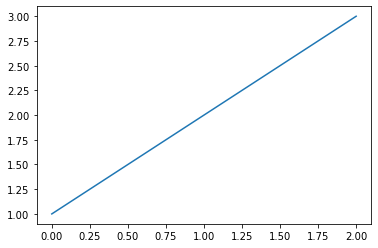

In [1]:
from matplotlib import pyplot as plt
plt.plot([1,2,3])
import numpy as np
import scipy
import scipy.spatial as spatial
import copy
from Environment.Builder_Env import Structure_Builder, circle, assignment
from RL.sac import sac_agent
import matplotlib
import torch
from Environment.data_visualization import show_reset, show_done, show_step, plot_large_frame
from Environment.episode_memory import Episode_Memory
matplotlib.rcParams['image.cmap'] = 'gray'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

In [41]:
import importlib
import Builder_Env
importlib.reload(Builder_Env)
from Builder_Env import Structure_Builder

In [9]:
import scipy.spatial as spatial
from scipy.optimize import linear_sum_assignment
def assignment(start, goal):
    cost_matrix = spatial.distance.cdist(np.array(start)[:,:2], np.array(goal)[:,:2])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    cost = cost_matrix[row_ind, col_ind]
    total_cost = np.sum(cost)
    return np.array(start)[row_ind,:], np.array(goal)[col_ind,:], cost, total_cost


In [10]:
a = np.random.random((10,2))
b = np.random.random((5,2))
assignment(a,b)

(array([[0.23789327, 0.17708525],
        [0.76814817, 0.32264964],
        [0.87478655, 0.82611956],
        [0.06763632, 0.95426914],
        [0.69546548, 0.20444345]]),
 array([[0.41497603, 0.50417661],
        [0.57656288, 0.38647369],
        [0.81424443, 0.48985469],
        [0.41548081, 0.81225907],
        [0.60865994, 0.23536862]]),
 array([0.37195035, 0.2019367 , 0.3416715 , 0.37571618, 0.09214971]),
 1.3834244339841324)

In [22]:
np.vstack([np.array([1,2])]).shape[0]

1

In [3]:
folder = 'building_4'

In [4]:
def RL_operation(env, agent, destination_nm, atom_nm, anchor_nm, i_episode, max_steps=5):
    #change len_nm based on anchor/ destination position
    len_nm = 2*max(np.max(np.abs(anchor_nm - atom_nm)), 2)+2
    offset_nm = atom_nm +np.array([0,-0.5*len_nm])
    done = False
    state, info = env.reset(destination_nm, anchor_nm, offset_nm, len_nm, large_len_nm)
        
    show_reset(env.img_info, env.atom_start_absolute_nm, env.destination_absolute_nm)
    episode_memory.update_memory_reset(env.img_info, i_episode, info)
    
    for step in range(max_steps):
        print('step:', step)
        action = agent.select_action(state)
        next_state, reward, done, info = env.step(action)
        mask = float(not done)
        episode_memory.update_memory_step(state, action, next_state, reward, done, info)
        state=next_state
        show_step(env.img_info, info['start_nm']+env.atom_absolute_nm, info['end_nm']+env.atom_absolute_nm,env.atom_absolute_nm, 
                  env.atom_start_absolute_nm, env.destination_absolute_nm, 
                  action[4]*env.max_mvolt, action[5]*env.max_pcurrent_to_mvolt_ratio*action[4]*env.max_mvolt)
        if done:
            episode_memory.update_memory_done(env.img_info, env.atom_absolute_nm, np.array([0,0]))
            episode_memory.save_memory(folder)
            break
    return env.atom_absolute_nm, env.dist_destination

def align_design(atoms, design):
    assert atoms.shape == design.shape
    c_min = np.inf
    for i in range(atoms.shape[0]):
        for j in range(design.shape[0]):
            a = atoms[i,:]
            d = design[j,:]
            design_ = design+a-d
            a_index = np.delete(np.arange(atoms.shape[0]), i)
            d_index = np.delete(np.arange(design.shape[0]), j)
            a, d, _, c = assignment(atoms[a_index,:], design_[d_index,:])
            if (c<c_min):
                c_min = c
                atoms_assigned, design_assigned = a, d
    return atoms_assigned, design_assigned, c_min, atoms[i,:]

In [7]:
batch_size= 64
LEARNING_RATE = 0.0003
agent = sac_agent(num_inputs = 4, num_actions = 6, action_space = None, device=device, hidden_size=256, lr=LEARNING_RATE,
                 gamma=0.9, tau=0.005, alpha=1)
agent.critic.load_state_dict(torch.load('training_4/reward_2_critic_3000.pth'))
agent.policy.load_state_dict(torch.load('training_4/reward_2_policy_3000.pth'))
agent.alpha = torch.load('training_4/reward_2_alpha_3000.pth')
episode_memory = Episode_Memory()

In [45]:
step_nm = 0.4
max_mvolt = 15 #min_mvolt = 0.5*max_mvolt
max_pcurrent_to_mvolt_ratio = 6E3 # min = 0.5*max
goal_nm  = 2
current_jump  = 4
large_len_nm = 9.033
large_offset_nm = np.array([8.457,317.641])
pixel = 128
scan_mV = 1000
max_len = 5
env = Structure_Builder(step_nm, max_mvolt, max_pcurrent_to_mvolt_ratio, goal_nm, 
                 current_jump, large_len_nm, large_offset_nm, pixel, scan_mV, max_len)
all_atom_absolute_nm, img_forward, img_backward, offset_nm, len_nm = env.scan_all_atoms(large_offset_nm, large_len_nm)    

succeed to connect


In [2]:
design_nm = np.array(circle(0,0,2.5,p=7)).T

NameError: name 'circle' is not defined

In [ ]:
### Set design offset values
fig, ax = plt.subplots()
extent = (offset_nm[0]-0.5*len_nm[0], offset_nm[0]+0.5*len_nm[0], offset_nm[1]+len_nm[0], offset_nm[1])
ax.imshow(img_forward, extent = extent)
ax.scatter(all_atom_absolute_nm[:,0],all_atom_absolute_nm[:,1],edgecolor='#A53860', linewidth=3, s=100)
    
atoms_assigned, design_assigned, c_min, anchor_nm = align_design(all_atom_absolute_nm, design_nm)

np.save(folder+'/design.npy', design_assigned)

for i in range(design_assigned.shape[1]):
    x, y = circle(design_assigned[i,0], design_assigned[i,1], 0.75)
    ax.plot(x,y, color='#A45D5D')

In [ ]:
acceptable_d = 1.5
precision = 0.2
max_step = 2      
def find_path(start, goal, i, max_step):
    start_ = copy.copy(start) 
    all_paths, paths_len = [], []
    all_len = 0
    s = start[i][:2]
    g = goal[i][:2]
    print('start:',s, 'goal',g)
    obstacleList = copy.copy(start)
    obstacleList.pop(i)
    rrt = RRT(
        start=s, goal=g, rand_area=[-2, 15],
        obstacle_list=obstacleList, expand_dis= max_step, path_resolution=1)
    path_len = np.inf
    min_path = None
    for _ in range(10):
        path = rrt.planning(animation=False)
        if len(path)<path_len:
            min_path = path
            path_len = len(path)
    return min_path

def get_atom_and_anchor(all_atom_absolute_nm, anchor_nm):
    i = np.argmin(spatial.distance.cdist(all_atom_absolute_nm, anchor_nm.reshape(-1,2)))
    new_anchor_nm = all_atom_absolute_nm[i,:]
    atoms_nm = np.delete(all_atom_absolute_nm, i, axis=0)
    return atoms_nm, new_anchor_nm
    
def reset_large_scan_frame(design):
    all_atom_absolute_nm, img_forward, img_backward, offset_nm, len_nm = env.scan_all_atoms(large_offset_nm, large_len_nm)    
    atoms_nm, new_anchor_nm = get_atom_and_anchor(all_atom_absolute_nm, anchor_nm)
    atoms, design, _, _ = assignment(atoms_nm, design) 
    
    img_info = {'img_forward':img_forward,'img_backward':img_backward, 'offset_nm':offset_nm, 'len_nm':len_nm, 
                'all_atom_absolute_nm':all_atom_absolute_nm, 'all_atom_absolute_nm_f':env.all_atom_absolute_nm_f,
                'all_atom_absolute_nm_b':env.all_atom_absolute_nm_b, 'design': design}
    if np.sum(cost<precision)>0:
        anchors = np.concatenate((all_atom_absolute_nm[anchor_atom_ind,:], atoms_[cost<precision,:]))
    else:
        anchors = all_atom_absolute_nm[anchor_atom_ind,:].reshape((-1,2))
        
    if np.max(cost)>precision:
        building_done = False
    else:
        building_done = True
        return building_done, None, None, img_info
    
    if not building_done:
        atoms = np.hstack((all_atom_absolute_nm, acceptable_d*np.ones(all_atom_absolute_nm.shape[0]))).tolist()
        goals = np.hstack((design, acceptable_d*np.ones(design_i.shape[0]))).tolist()
        a_ind = np.argmax(cost)
        path = find_path(atoms, goals, a_ind, max_step)
        j = -1
        while True:
            s = path[j]
            d = path[j-1]
            j -=1
            if np.linalg.norm(np.array(s) - np.array(d))>precision:
                break
        print(atoms[a_ind,:], s)
        assert np.allclose(atoms[a_ind,:],s)
        arg = np.argmin(spatial.distance.cdist(atoms[a_ind,:].reshape((-1,2)), anchors))
        anchor = anchors[arg,:]
        plot_large_frame(img_forward, offset_nm, len_nm, goals, atoms, a_ind)
        return building_done, d, atoms[a_ind,:], img_info, design, anchor

The scan will take 38.7 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 1.9607634369450528
[0.07343751 0.62984133 0.1403289  0.09483586 0.11615809 0.63020058
 0.27596117]
[0.         1.60907303 1.12840825 3.86566981 0.20447529 1.84573998
 3.45424682]
[1.50098337 0.         3.76139508 0.20271149 4.84482719 3.66442144
 2.16461709]
[2.18531046 3.27159177 0.         2.07512223 1.66899588 1.14774112
 0.06260915]
[1.24417252 0.24362939 3.50708069 0.         4.61699069 3.46049638
 1.97387518]
[3.53108031 4.93428731 1.2627562  4.44832221 0.         1.00946576
 2.41148694]
[0.84213508 0.89159076 2.41440523 2.6419517  1.99299057 0.
 1.7329237 ]
[3.00896754 3.80544271 0.98371493 2.12004609 0.92122933 0.79540454
 0.        ]
destination: [  9.5587245  320.04542129] start: [  9.23328169 319.50617453]
The scan will take 38.7 seconds
forward: [  9.2902505 319.4750171] backward: [  9.13713618 319.47581164]


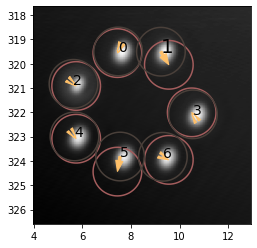

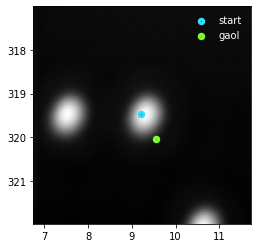

step: 0
-0.05430306196212769 -0.22077016830444338 1.1205661296844482 1.450760006904602 5.718827247619629 26141.257584328057
63 58 93 101
The scan will take 38.7 seconds
forward: [  9.90418935 320.04890578] backward: [  9.75230224 320.04645285]
atom moves by: 0.8397391762255355
None


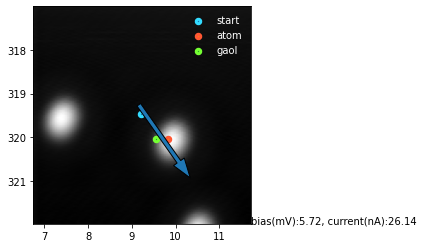

step: 1
0.39414868354797367 -0.1584420680999756 0.3382915109395981 1.2052340805530548 7.908776700496674 26434.066728714748
90 74 88 109
The scan will take 38.7 seconds
forward: [  9.68679156 320.4240969 ] backward: [  9.53238222 320.41860735]
atom moves by: 1.0254413385882328
None


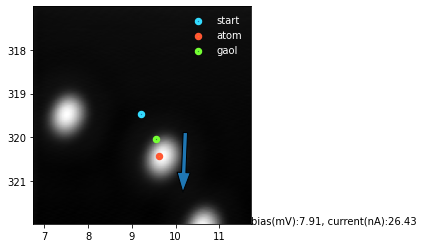

step: 2
0.3505389213562012 -0.053467708826065066 0.4011834114789963 0.3977288603782654 9.820487201213837 44758.18164285837
83 87 84 98
The scan will take 38.7 seconds
forward: [  9.32190346 320.71843165] backward: [  9.16733968 320.71625857]
atom moves by: 1.2423157870734134
None


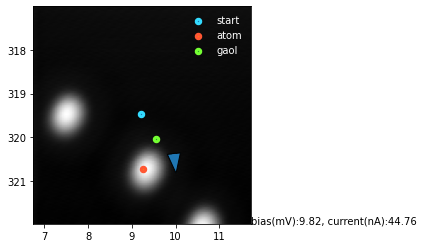

step: 3
-0.19880853891372682 0.01199343055486679 0.7336315959692001 0.2525632157921791 7.4732208251953125 41566.852726664365
60 96 84 102
The scan will take 38.7 seconds
forward: [  9.48485111 320.00856525] backward: [  9.33067395 320.00607146]
atom moves by: 0.5662019931491081
None


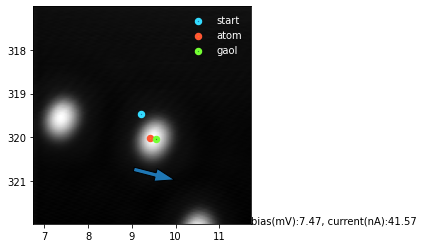

step: 4
0.1815088987350464 -0.029174983501434326 0.6962859034538269 1.13901686668396 6.9504766166210175 21945.36452512093
74 77 87 107
The scan will take 38.7 seconds
forward: [  9.79507586 320.29680277] backward: [  9.64126235 320.29488881]
None


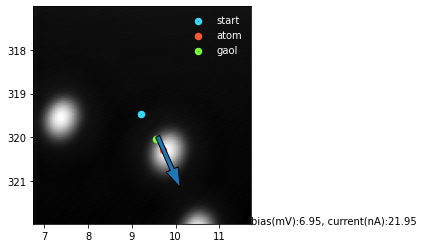

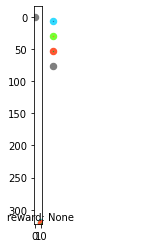

The scan will take 38.7 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 2.074653684300375
[0.1338841  0.29865056 0.2693407  0.16092449 0.231791   0.5746346
 0.40542823]
[0.         0.22354934 1.70205582 1.86404103 3.80979653 4.20955463
 3.84070869]
[1.58816548 0.         3.85462819 0.45158733 5.02082868 3.90854718
 2.448566  ]
[1.60975015 1.23672129 0.         0.46329995 2.13401051 2.65301917
 2.3871976 ]
[4.02457068 1.69997817 4.54178245 0.         3.10104411 1.136057
 0.20514967]
[3.78641368 3.50624452 2.1185539  1.84255715 0.         0.44502015
 0.11497966]
[0.22277128 2.57267889 1.70031525 3.11056845 1.81789687 0.
 1.75373415]
[3.88802101 3.62047604 2.21245606 1.96189244 0.09622241 0.33871564
 0.        ]
destination: [  9.5587245  320.04542129] start: [  9.72388952 320.29424388]
The scan will take 38.7 seconds
forward: [  9.78114677 320.27380614] backward: [  9.62830875 320.27112651]


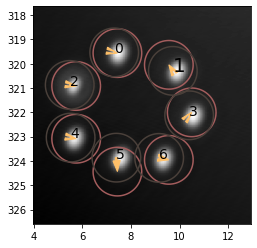

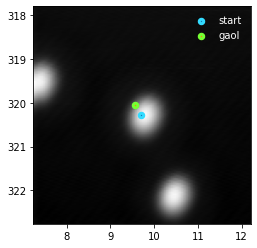

step: 0
0.23916797637939455 0.36401891708374023 0.2379414215683937 0.296053871512413 7.6054564118385315 43712.67942950581
70 73 70 71
None


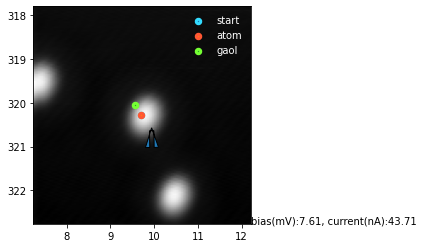

step: 1
0.0848548173904419 0.35187635421752933 0.27647922188043594 0.19588156789541245 5.297988653182983 23449.786392170325
66 73 71 69
None


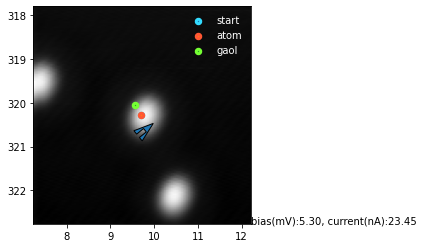

step: 2
-0.006111479923129082 0.3561877489089966 0.15202180668711662 0.2710050791501999 7.845567762851715 35661.904190105
64 73 68 71
The scan will take 38.7 seconds
forward: [  9.43828766 319.81865165] backward: [  9.28493332 319.81485513]
atom moves by: 0.5704417037516805
None


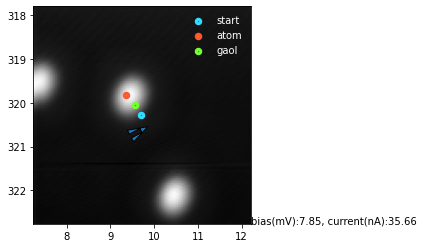

step: 3
0.0006133253686130048 0.17775309085845947 0.7617618441581726 0.8493205904960632 8.044102191925049 43563.68827121628
55 57 75 74
The scan will take 38.7 seconds
forward: [  9.56091447 319.72766935] backward: [  9.40525839 319.7238487 ]
atom moves by: 0.5899269010884878
None


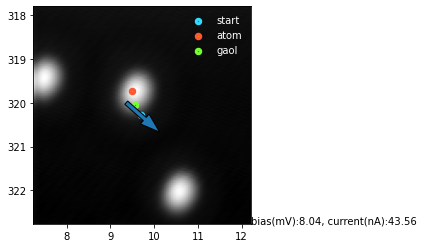

step: 4
-0.03595277667045593 0.28950750827789307 0.7192925065755844 0.7646423578262329 9.151861667633057 40204.480755784854
57 57 77 69
The scan will take 38.7 seconds
forward: [  9.65032442 319.45269522] backward: [  9.49934705 319.45116951]
None


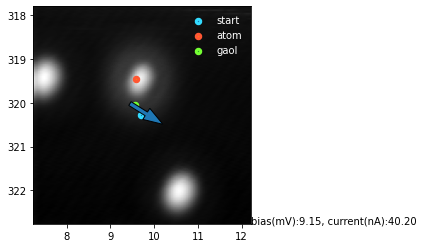

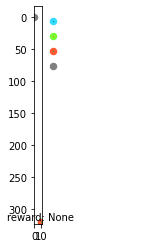

The scan will take 38.7 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 2.2320973174049694
[0.15242479 0.60213027 0.22834554 0.00847121 0.19975735 0.69230803
 0.34866013]
[0.         2.14729748 2.0173738  2.65488525 2.30018015 0.56565006
 1.16945028]
[2.17486637 0.         3.91858942 1.07151516 3.73120617 1.7998367
 0.04591984]
[2.24547907 3.75578178 0.         2.5747206  1.50633376 0.76804534
 0.4618862 ]
[1.3053183  0.54388638 3.5698287  0.         4.64727137 3.46076558
 1.96044607]
[3.49389115 5.24818716 1.22031801 4.49907987 0.         1.05259612
 2.47736038]
[0.52709054 1.64256741 2.21830234 2.8014597  1.95491262 0.
 1.7491582 ]
[2.56046099 3.7552106  0.41955645 2.14249329 1.34873635 0.97716884
 0.        ]
destination: [  9.5587245  320.04542129] start: [  9.59797528 319.44457169]
The scan will take 38.7 seconds
forward: [  9.65828662 319.43853215] backward: [  9.50524886 319.4336408 ]


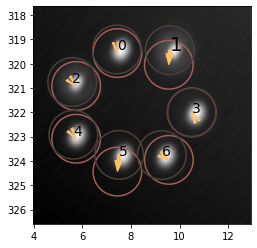

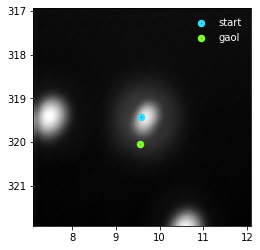

step: 0
0.29529237747192383 -0.2114654779434204 0.4848267138004303 1.439863532781601 5.503995269536972 29322.627889808875
72 59 76 101
The scan will take 38.7 seconds
forward: [  9.5425196  320.91857747] backward: [  9.38084491 320.93813013]
atom moves by: 1.4970912784466435
None


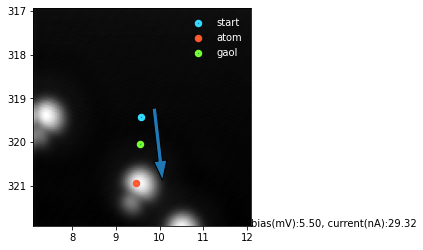

step: 1
-0.1712495803833008 0.3625706434249878 0.7288353592157364 0.23450589179992676 7.003835141658783 39323.410943215116
56 112 80 109
The scan will take 38.7 seconds
forward: [  9.76475084 320.12672818] backward: [  9.60690302 320.12510474]
atom moves by: 0.6976343772421726
None


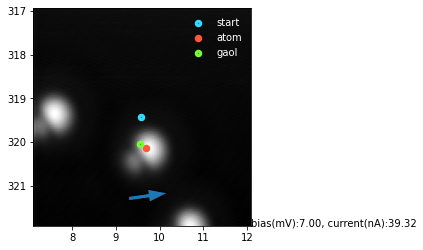

step: 2
0.0677992820739746 0.015418943762779237 0.271586649119854 1.1216709315776825 8.668066263198853 36743.284679414784
68 82 74 111
The scan will take 38.7 seconds
forward: [  9.64380981 321.26536903] backward: [  9.48309653 321.25965559]
atom moves by: 1.826517658931445
None


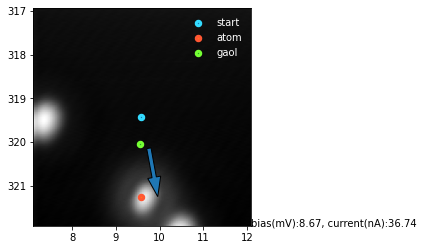

step: 3
-0.25950930118560794 0.32784409523010255 0.04664832539856434 -0.16220969706773758 10.413282215595245 48723.77997067798
57 120 65 107
The scan will take 38.7 seconds
forward: [  9.63405702 321.13413119] backward: [  9.47888734 321.13306508]
atom moves by: 1.6977001249141948
None


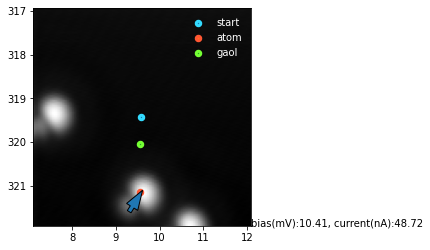

step: 4
-0.009697293490171434 0.24017319679260254 0.2816050797700882 0.23455531150102615 14.498083591461182 85890.4394592048
63 114 71 114
The scan will take 38.7 seconds
forward: [  9.75182432 321.02944914] backward: [  9.59876124 321.03253018]
None


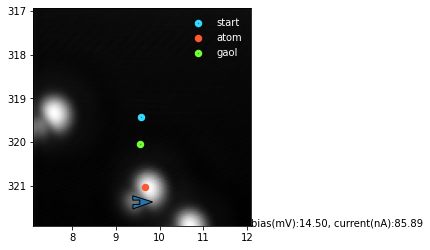

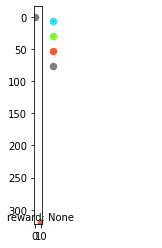

The scan will take 38.7 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 3.04231549044525
[0.26738829 0.21537311 1.00515608 0.1527468  0.26065867 0.80560041
 0.33539213]
[0.         1.2301629  2.63210404 3.83861237 0.31010908 1.7487082
 3.3786872 ]
[2.39605879 0.         3.09859873 3.3506265  1.1237854  0.09205074
 1.32834924]
[1.91113946 3.9930178  0.         0.83578817 4.11218431 2.34009126
 0.59013852]
[3.90281204 3.86763407 1.25621829 0.         2.10004914 0.32656772
 0.70617722]
[1.76155702e+00 1.50179891e-01 3.91040901e+00 4.86468183e+00
 1.12317130e-15 1.89244227e+00 3.65558163e+00]
[1.11304596 2.64657351 1.36733204 2.49162057 2.02742311 0.
 1.71437599]
[0.46277798 1.91112372 1.5030205  1.91593859 2.7976661  1.54375752
 0.        ]
destination: [  7.44369767 319.56268022] start: [  7.5464574  319.31582614]
The scan will take 38.7 seconds
forward: [  7.6609411  319.30825614] backward: [  7.51260619 319.30059914]


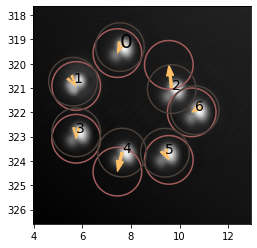

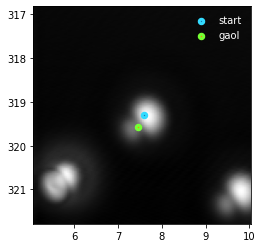

step: 0
0.22885696887969972 0.19319928884506227 0.18953613191843033 1.087484210729599 7.046691924333572 41274.63931402257
71 69 70 92
The scan will take 38.7 seconds
forward: [  7.27840599 319.33273096] backward: [  7.01265101 319.29712156]
atom moves by: 0.4413700227373123
None


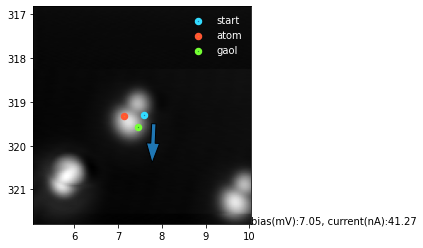

step: 1
-0.20267770290374756 0.2621947288513184 0.74786277115345 1.0114983916282654 5.907084345817566 21875.461807311895
49 71 73 90
The scan will take 21.0 seconds
forward: [  7.53390297 319.40288837] backward: [  7.39459901 319.40347444]
atom moves by: 0.15736615043892715
None


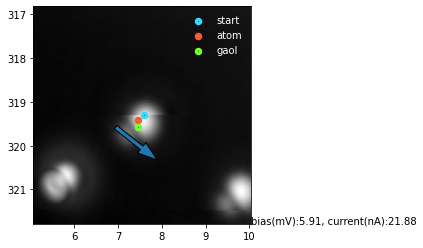

step: 2
0.11434928178787232 0.2987562656402588 0.31936436891555786 0.8503760397434235 6.188517361879349 30598.774223522545
65 74 71 89
None


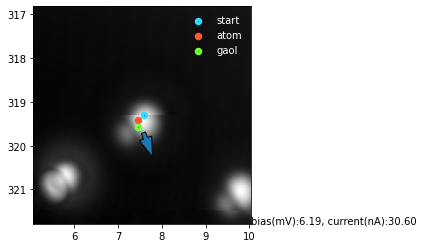

step: 3
0.1415761113166809 0.24990296363830566 0.28735750168561935 0.8662326335906982 5.568360686302185 18629.816892960134
66 73 70 89
The scan will take 21.0 seconds
forward: [  7.48015528 319.34069713] backward: [  7.18640571 319.34350958]
atom moves by: 0.25627765138241065
None


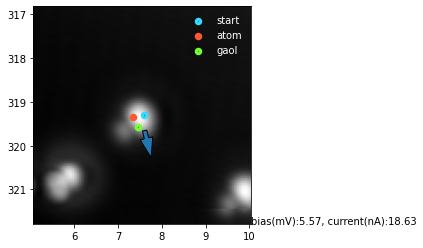

step: 4
0.07051594853401184 0.2626130819320679 0.5561010539531708 1.0403067469596863 7.747333645820618 28849.943583662993
61 72 73 92
The scan will take 41.9 seconds
forward: [  7.54822891 319.40117224] backward: [  7.40417101 319.4017432 ]
None


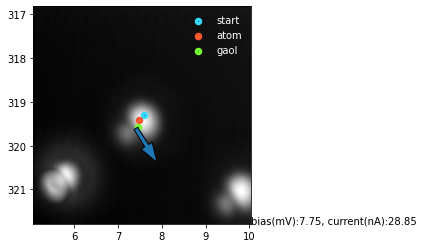

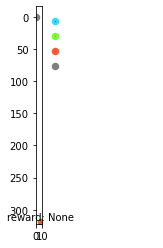

The scan will take 41.9 seconds
[  8.457 317.641]
[8.94314 8.94314]
total movement: 3.036953963486207
[0.16740564 0.24546691 0.97515633 0.17289577 0.28488742 0.83933752
 0.35180437]
[0.         1.79809958 2.23980687 3.16585207 1.71096415 0.16290313
 1.91440251]
[2.13499139 0.         3.63852042 4.1840067  0.67663402 0.77064652
 2.39315903]
[2.00153365 3.95322179 0.         0.79923248 4.14855949 2.40364812
 0.67243584]
[3.95152662 4.07922061 1.27327104 0.         2.37291757 0.54500355
 0.5756745 ]
[1.4477832  0.24804462 3.80597053 4.79715024 0.         1.93263659
 3.68171431]
[1.23418544 2.64902696 1.34891517 2.47095766 2.02660252 0.
 1.70274536]
[0.15773678 2.01714918 1.44799514 1.88798232 2.86931604 1.55737529
 0.        ]
destination: [  5.74757783 320.91529065] start: [  5.65720188 320.68706666]
The scan will take 41.9 seconds
forward: [  5.76182322 320.72486506] backward: [  5.61222054 320.7253146 ]


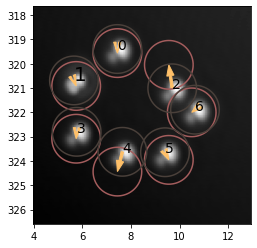

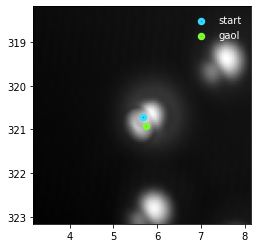

step: 0
0.2485372304916382 0.2015464544296265 0.4258240610361099 0.7806412875652313 5.7625991106033325 17937.12263781103
72 71 76 86
The scan will take 41.9 seconds
forward: [  5.75797843 320.68718801] backward: [  5.6140954  320.68426896]
atom moves by: 0.039373663382143584
None


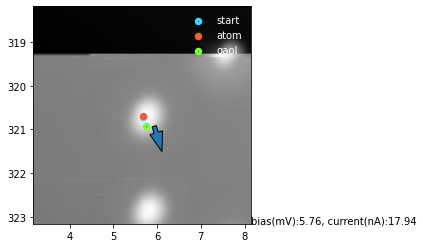

step: 1
0.0509405255317688 0.017418257892131805 0.6039330661296844 0.8662186861038208 9.226190149784088 29314.731195160453
66 65 81 87
The scan will take 41.9 seconds
forward: [  5.90033042 320.72751581] backward: [  5.75552846 320.72631674]
atom moves by: 0.1409193955960266
None


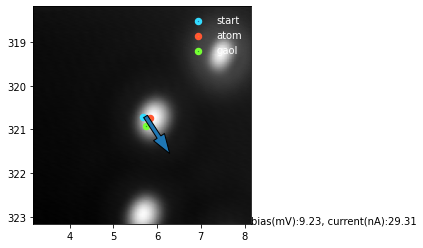

step: 2
0.07811339497566223 0.08926128745079041 0.42030447721481323 0.8135527968406677 8.031025528907776 26780.779270191957
71 68 80 86
None


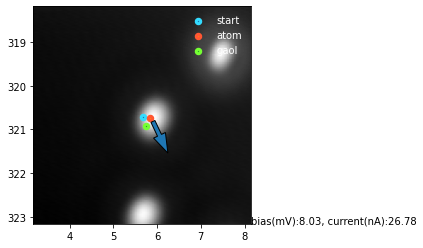

step: 3
0.2646806240081787 0.14405993223190308 0.3179349973797798 0.8765748739242554 9.676845073699951 29769.971172636928
76 69 77 88
The scan will take 41.9 seconds
forward: [  5.61803052 320.60976938] backward: [  5.47312832 320.60608688]
atom moves by: 0.18366500251343792
None


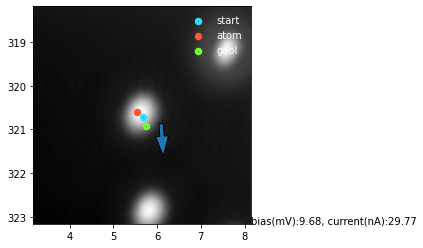

step: 4
-0.1381741166114807 0.16548161506652834 0.723434329032898 0.9111416637897491 5.972668826580048 23820.668853556555
58 67 80 86
The scan will take 41.9 seconds
forward: [  5.76337292 320.66827131] backward: [  5.61980543 320.66757331]
None


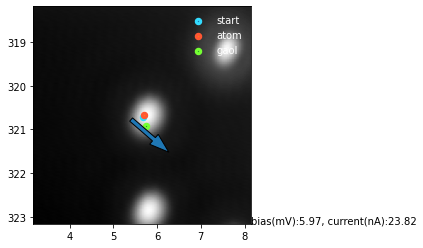

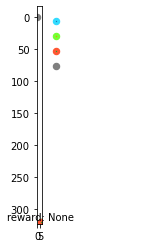

In [48]:
max_steps = 5
for i in range(35,40):
    building_done, d, s, img_info, design, anchor = reset_large_scan_frame(design)
    if building_done:
        break
    np.save(folder+'/{}_episode_img_info.npy'.format(i),img_info)
    small_len_nm = 5
    print('destination:',d, 'start:',s)
    atom_nm, dist_destination = RL_operation(env, agent, d, s, anchor, i)